<h1>Principal Component Analysis Versus Linear Regression<span class="tocSkip"></span></h1>

* This Jupyter notebook accompanies the **Linear Algebra** course in the [ICME Summer Workshops in Data Science](https://icme.stanford.edu/icme-summer-workshops-2021-fundamentals-data-science#LinAlg) (2021) series. 
* This course is taught by Laura Lyman and Professor Margot Gerritsen. 

In this module, we explore some of the differences between ordinary least squares (i.e. linear regression) and principal component analysis. To follow along, you can interatively run and update blocks of code. After clicking into a single code block, type `Shift Enter` to execute it. Keep in mind that some code blocks have dependencies on previous blocks, and therefore the blocks should be evaluated in order. 

# Introduction

Ordinary least squares (OLS) and principal component analysis (pca) are both popular techniques in data science for accomplishing similar goals. Both methods pick the "best" linear relationships for approximating some response variable $y$ in terms of a set of explanatory variables $x_1, \ldots, x_p.$ In particular, OLS and pca each pick linear models that minimize the "error" between the actual observed values of $y$ and the $y$ values predicted by the model. The key difference is that OLS and pca define "error" differently. 

Before stating symbolically how OLS and pca measure error, we will show such errors visually in the following example. This will provide the geometric intuition that sits at the *heart* of how these methods work. 

give the visual and geometric intuition at the heart of these measurements. 


*This module is meant to be a light-hearted, interactive, and hands-on exploration of these data science methods rather than an exhaustive overview of their details.*


will show the errors visually in the following example. 

the intuition at the heart of the  

establish the visual and geometric intuition at the heart of 

intuition at the heart  

Instead, we will provide some visual and geometric intuition for what each of these methods is optimizing/minimizing by examining 

model some dependent (scalar) variable $y$ as a linear function of a set of explanatory variables $x_1, \ldots, x_p.$ 


OLS selects the linear function that minimizes the sum of (squared) differences between the observed response values $y_i$ and the values predicted by the linear function of the explanatory variables. This is seen geometrically by the vertical (or horizontal) differences between ...

Of course, we say "the" because the OLS solution is unique .... and always exists? ...

However, pca minimizes the error orthogonal (perpendicular) to the model line"

minimzes the sum of the squares of the differences between the observed dependent variable (values of the variable being observed) in the given dataset and those predicted by the linear function of the independent variable.


OLS tries to approximate some dependent (scalar) variable $y$ as a linear function of a set of explanatory variables $x_1, \ldots, x_p.$ 

In particular, OLS selects such a linear relationship that "best" matches the actual observed values of $y$, where the define the best linear model to be the one that minimzes the sum of the squares of the differences between the observed dependent variable (values of the variable being observed) in the given dataset and those predicted by the linear function of the independent variable.

selects or "fits" a linear relationship between a dependent (scalar) variable $y$ and a set of explanatory variables/parameters $x_1, \ldots, x_p$ that best matches the actual observed data points. 

In two dimensions, 

given a dependent/response variable $y$ and some explanatory variables $x_1, \ldots, x_p$, OLS finds the "best" line 

provide the best linear 


given explanatory variables $x_1, \ldots, x_p$ and a variable $y$ that dependeds 

OLS picks a subset of explanatory variables such that some dependent 

OLS chooses a subset 

However, the differences between the two are often glossed over or left unaddressed.

1. OLS $y \sim x$ minimizes vertical distances/residuals
2. OLS $x \sim y$ minimizes horizontal distances/residuals
3. pca minimizes the orthogonal projections of the linear approximation onto the actual data

The intent of this Jupyter notebook is not to mathematically prove statements 1 - 3, though such arguments can be found in **insert references**. Instead, we will provide some visual and geometric intuition for what each of these methods is optimizing/minimizing by examining 

In terms of technical details, we assume all variables are real valued. The point of this module is to explore and interact with how these techniques can be applied to real data.. The formal proofs for such things are fine but are reserved for **insert references**...


Again, 


**Abbreviation Glossary**
* (pca) principal component analysis as a general technique...
* (PCA) Principal Component Analysis (*capitalized*) -- a version of pca (*lowercase*) that specifically utilizes an eigendecomposition/spectral decomposition to compute the principal components and values of a data set

In [1]:
from   numpy import genfromtxt
import numpy as np
import math
import matplotlib.pyplot as plt
import random

# Optional; suppresses scientific notation
np.set_printoptions(suppress=True)

In [2]:
## TO DO: Are the columns features, or something else? Is that the right word for them?
def center_matrix(X):
    [n,p]     = X.shape
    X_c       = np.zeros_like(X)
    # Subtract off the mean of each property i.e. subtract from each column the avg. of that column 
    for feature_idx in range(p):
        X_c[:,feature_idx] = X[:,feature_idx] - np.mean(X[:,feature_idx])
    return(X_c)


# Numerical Application & Example: Heart Health

Suppose the following matrix $X$ contains resting heart rate (HR) and diastolic blood pressure (BP) data for healthy adolescent women aged 14 - 16. (The data was simulated based off the means and standard deviations from actual patient data given in **academic paper**). 

In [3]:
X = np.array([[69.57, 76.90], [61.81, 66.66], [71.62, 59.56], \
              [58.59, 69.39], [63.18, 62.82], [62.27, 60.44], \
              [65.96, 72.60], [59.25, 61.56], [63.68, 82.86], \
              [49.48, 42.08]], dtype = np.float64)

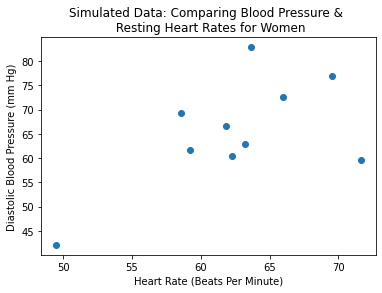

In [4]:
fig = plt.subplots()
plt.scatter(X[:,0],X[:,1])
plt.xlabel("Heart Rate (Beats Per Minute)")
plt.ylabel("Diastolic Blood Pressure (mm Hg)")
plt.title("Simulated Data: Comparing Blood Pressure & \n Resting Heart Rates for Women")
plt.show()

In [5]:
import copy
X_c = copy.deepcopy(center_matrix(X))
X_c

array([[  7.029,  11.413],
       [ -0.731,   1.173],
       [  9.079,  -5.927],
       [ -3.951,   3.903],
       [  0.639,  -2.667],
       [ -0.271,  -5.047],
       [  3.419,   7.113],
       [ -3.291,  -3.927],
       [  1.139,  17.373],
       [-13.061, -23.407]])

In [6]:
C = 1/X_c.shape[0] * np.matmul(np.transpose(X_c), X_c)

In [7]:
C

array([[ 34.286889,  37.254583],
       [ 37.254583, 113.030521]])

In [8]:
[Lambda,V] = np.linalg.eig(C)
Lambda

array([ 19.45497958, 127.86243042])

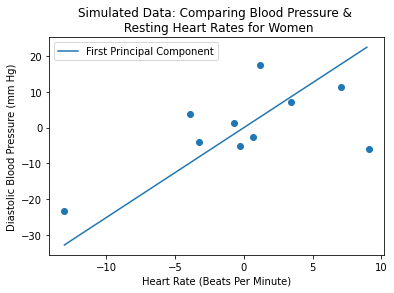

In [9]:
fig, ax = plt.subplots()
plt.scatter(X_c[:,0],X_c[:,1])
plt.xlabel("Heart Rate (Beats Per Minute)")
plt.ylabel("Diastolic Blood Pressure (mm Hg)")
plt.title("Simulated Data: Comparing Blood Pressure & \n Resting Heart Rates for Women")

x_axis = np.arange(np.min(X_c[:,0]), np.max(X_c[:,0]))

# Careful! Lambda isn't ordered here like it should be, so actually the second column of V corresponds
# to the principal component
prin_comp_vec = V[:,1]
prin_comp_line = lambda x: prin_comp_vec[1]/prin_comp_vec[0]*x
plt.plot(x_axis,prin_comp_line(x_axis))

plt.legend(['First Principal Component'])

plt.show()

In [10]:
X

array([[69.57, 76.9 ],
       [61.81, 66.66],
       [71.62, 59.56],
       [58.59, 69.39],
       [63.18, 62.82],
       [62.27, 60.44],
       [65.96, 72.6 ],
       [59.25, 61.56],
       [63.68, 82.86],
       [49.48, 42.08]])

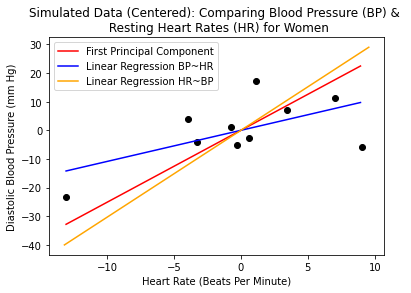

In [11]:
fig, ax = plt.subplots()
plt.scatter(X_c[:,0],X_c[:,1], c = 'black')
plt.xlabel("Heart Rate (Beats Per Minute)")
plt.ylabel("Diastolic Blood Pressure (mm Hg)")
plt.title("Simulated Data (Centered): Comparing Blood Pressure (BP) & \n Resting Heart Rates (HR) for Women")

x_axis = np.arange(np.min(X_c[:,0]), np.max(X_c[:,0]))
# y_axis = np.arange(np.min(X_c[:,1]), np.max(X_c[:,1]))
y_axis = np.arange(-40,30)
# Careful! Lambda isn't ordered here like it should be, so actually the second column of V corresponds
# to the principal component
prin_comp_vec = V[:,1]
prin_comp_line = lambda x: prin_comp_vec[1]/prin_comp_vec[0]*x
plt.plot(x_axis,prin_comp_line(x_axis), c = 'red')


m, b = np.polyfit(X_c[:,0], X_c[:, 1],1)
plt.plot(x_axis, m*x_axis + b, 'blue')

m_x, b_x = np.polyfit(X_c[:,1], X_c[:, 0], 1)
plt.plot(m_x*y_axis + b_x, y_axis, 'orange')
# pred_DBP = model.predict(x_axis)
# print(pred_DBP)
# plt.plot(x_axis, pred_DBP)
# plt.show()
plt.legend(['First Principal Component', 'Linear Regression BP~HR', 'Linear Regression HR~BP'])
plt.show()

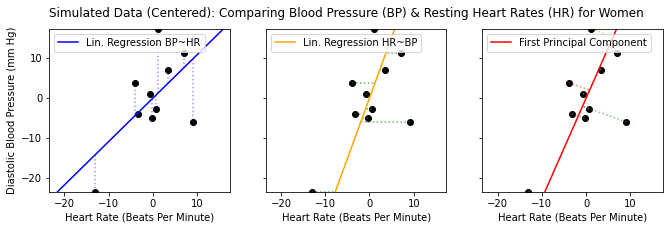

In [12]:
plt.close('all')
# %matplotlib notebook
fig, axs = plt.subplots(1, 3,  figsize=(11, 3), sharey=True)

axs[0].set_xlabel("Heart Rate (Beats Per Minute)")
axs[1].set_xlabel("Heart Rate (Beats Per Minute)")
axs[2].set_xlabel("Heart Rate (Beats Per Minute)")
axs[0].set_ylabel("Diastolic Blood Pressure (mm Hg)")

# axs[0].set_xlim(-25,25)
# axs[1].set_xlim(-25,25)
# axs[2].set_xlim(-25,25)
# axs[0].set_ylim(-25,25)
# axs[1].set_ylim(-25,25)
# axs[2].set_ylim(-25,25)
axs[0].set_xlim(np.min(X_c[:,1]), np.max(X_c[:,1]))
axs[0].set_ylim(np.min(X_c[:,1]), np.max(X_c[:,1]))
axs[1].set_xlim(np.min(X_c[:,1]), np.max(X_c[:,1]))
axs[1].set_ylim(np.min(X_c[:,1]), np.max(X_c[:,1]))

# x_axis = np.arange(np.min(X_c[:,0]), np.max(X_c[:,0]))

# Force plots to be square so that we can properly view orthogonal components
x_axis = np.arange(np.min(X_c[:,1]), np.max(X_c[:,1]))

m, b = np.polyfit(X_c[:,0], X_c[:, 1],1)
line, = axs[0].plot(x_axis, m*x_axis + b, color = 'blue')
axs[0].vlines(X_c[:,0], m*X_c[:,0] + b, X_c[:,1], linestyles='dotted', color = 'blue', alpha = .4)
axs[0].scatter(X_c[:,0],X_c[:,1], c = 'black', alpha = 1)
axs[0].legend(['Lin. Regression BP~HR'], loc = 'upper left')

# y_axis = np.arange(np.min(X_c[:,1]), np.max(X_c[:,1]))
y_axis = np.arange(-40,30)


axs[1].plot(m_x*y_axis + b_x, y_axis, color = 'orange')
axs[1].hlines(X_c[:,1],X_c[:,0], m_x*X_c[:,1] + b_x, linestyles='dotted', color = 'green', alpha = .6)
axs[1].legend(['Lin. Regression HR~BP'], loc = 'upper left')
axs[1].scatter(X_c[:,0],X_c[:,1], c = 'black', alpha = 1)

axs[2].set_xlim(np.min(X_c[:,1]), np.max(X_c[:,1]))
axs[2].set_ylim(np.min(X_c[:,1]), np.max(X_c[:,1]))
axs[2].plot(x_axis,prin_comp_line(x_axis), color = 'red')


n = X_c.shape[0]
# Iterate through the data to compute orthogonals
for i in range(n):
    w  = X_c[i,:]
    cv = np.dot(prin_comp_vec,w)/np.linalg.norm(prin_comp_vec)*prin_comp_vec
    axs[2].plot([w[0],cv[0]],[w[1],cv[1]], linestyle = 'dotted', alpha = .6)
axs[2].scatter(X_c[:,0],X_c[:,1], c = 'black', alpha = 1)
axs[2].legend(['First Principal Component'], loc = 'upper left')    
fig.suptitle("Simulated Data (Centered): Comparing Blood Pressure (BP) & Resting Heart Rates (HR) for Women")

plt.show()


<IPython.core.display.Javascript object>


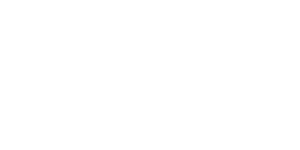

In [13]:
from matplotlib.widgets import Slider, Button
%matplotlib notebook
plt.close('all')

# Creates vertical lines between the true data points and the regression line
# with slope m and intercept b
# Of course assumes x_data_pts and y_data_pts have the same length (since these are coordinate pairs)
def make_vlines(x_data_pts, y_data_pts, m, b, first_run = True):
    sum_of_vert_dists = np.linalg.norm(m*x_data_pts + b - y_data_pts, 2)
    for i in range(x_data_pts.shape[0]):
        x_i      = x_data_pts[i]
        if first_run:
            vline, = ax.plot([x_i, x_i], [y_data_pts[i],  m*x_i + b], linestyle = 'dotted', \
                             alpha = .6, color = 'purple')
            the_vlines.append(vline)
        else: 
            the_vlines[i].set_ydata([y_data_pts[i], m*x_i + b])
    return(sum_of_vert_dists)
            
def animate(i):
    ax.clear()
    line.set_ydata((m+i)*x_axis + b)

    vlines = ax.vlines(X_c[:,0], (m+i-1)*X_c[:,0] + b, (m+i)*X_c[:,0] + b, linestyles='solid', color = 'purple')
    ax.set_ylim(-25,25)
    if i == 9:
        del vlines
    return line,ax

fig, ax = plt.subplots()
# ax = plt.axes()


plt.xlabel("Heart Rate (Beats Per Minute)")
plt.ylabel("Diastolic Blood Pressure (mm Hg)")

plt.scatter(X_c[:,0],X_c[:,1], c = 'purple', alpha = 1)

# Adjust the main plot to make room for the sliders
plt.subplots_adjust(left=0.25, bottom=0.25)

# Make a horizontal slider to control the fitting line
slopevals = plt.axes([0.25, 0.1, 0.65, 0.03])
slope_slider = Slider(
    ax = slopevals,
    label='Slope of fitting line',
    valmin = -2,
    valmax = 2,
    valinit = m
)

# plt.title("Simulated Data (Centered): Comparing Blood Pressure & \n Resting Heart Rates for Women")

x_axis = np.arange(np.min(X_c[:,0]), np.max(X_c[:,0]))
x_axis_full = np.arange(-25, 20)
# Force plot to look square
ax.set_xlim(-25,20)
ax.set_ylim(-25,20)


m, b       = np.polyfit(X_c[:,0], X_c[:, 1],1)
reg_line,  = ax.plot(x_axis_full, m*x_axis_full + b, linestyle = 'dashed', color = 'black', alpha = 0.5)
line,      = ax.plot(x_axis, m*x_axis + b, alpha = 1)
ax.legend(['True Regression Line', 'Linear Fit'])
the_vlines = []
# vlines = ax.vlines(X_c[:,0], m*X_c[:,0] + b, X_c[:,1], linestyles='solid', color = 'black')

sum_of_vert_dists = make_vlines(X_c[:,0], X_c[:, 1], m, b)

# Display the sum of residuals
resid_label = 'Sum of Vertical Distances (Residuals): '
plt.text(-3.5,28,resid_label, weight='bold')
resid_pt = plt.text(-.5, 28, '{:.2f}'.format(sum_of_vert_dists))

def update_slope(val):
    line.set_ydata(slope_slider.val*x_axis + b)
    sum_of_vert_dists = make_vlines(X_c[:,0], X_c[:,1], slope_slider.val, b, first_run = False)
    resid_pt.set_text('{:.2f}'.format(sum_of_vert_dists))
    fig.canvas.draw_idle()

slope_slider.on_changed(update_slope)
# ani = animation.FuncAnimation(
#     fig, animate, interval=20, frames = 10, blit=False, save_count=50, repeat = True)

# Create a `matplotlib.widgets.Button` to reset the sliders to initial values.
resetax = plt.axes([0.8, 0.025, 0.1, 0.04])
button = Button(resetax, 'Reset', hovercolor='0.975')

def reset(event):
    slope_slider.reset()
    fig.canvas.draw_idle()

button.on_clicked(reset)

plt.show()

<IPython.core.display.Javascript object>


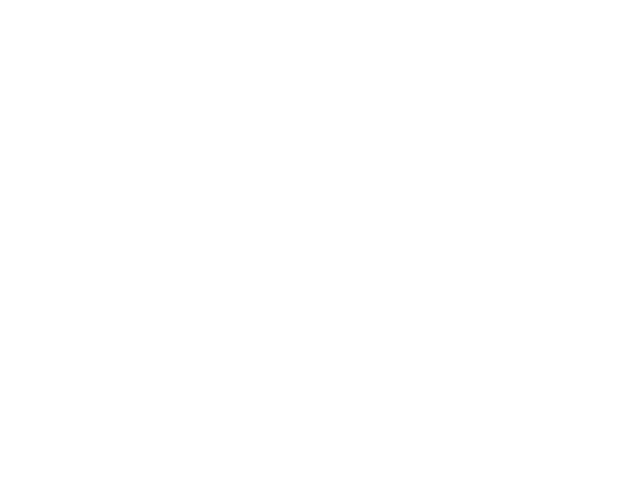

NameError: name 'animation' is not defined

In [14]:
from IPython.display import HTML
%matplotlib notebook

fig, ax = plt.subplots()

x = np.arange(0, 2*np.pi, 0.01)
line, = ax.plot(x, np.sin(x))


def animate(i):
    line.set_ydata(np.sin(x + i / 50))  # update the data.
    return line,


ani = animation.FuncAnimation(
    fig, animate, interval=20, blit=True, save_count=50)

# HTML(ani.to_html5_video())
# HTML(ani.to_jshtml())
# To save the animation, use e.g.
#
# ani.save("movie.mp4")
#
# or
#
# writer = animation.FFMpegWriter(
#     fps=15, metadata=dict(artist='Me'), bitrate=1800)
# ani.save("movie.mp4", writer=writer)

plt.show()

# When Should We Use Each Method? 

This is a great question. The context ...